Import libraries

In [1]:
import calendar
import cartopy.crs as ccrs
import cartopy.feature
import csv
import datetime
import json
import math
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import os
import pandas as pd
import re
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from datetime import date, timedelta
from matplotlib.patches import Rectangle
from netCDF4 import Dataset
from scipy.stats import linregress
import time

Read in TOAR ship model data

In [2]:
# Create a function to process the model output into a dataframe
def process_model_output_file(file_name, directory_path):
    if "zsurf_stash34001" not in file_name:
        # Skip files that do not contain "stash34001" in their names
        return None

    file_path = os.path.join(directory_path, file_name)

    with Dataset(file_path, 'r') as nc_file:
        data = {}  # Create an empty dictionary to store variable data

        # Define the variables you want and add them to the dictionary
        variable_list = ['time', 'latitude', 'longitude', 'region', 'm01s34i001']

        for variable in variable_list:
            data[variable] = nc_file.variables[variable][:]
    
    # Create a DataFrame for the current file
    return pd.DataFrame(data)

# Specify the directory path
directory_path = "/scratch/ajp255/homes/mrr32/home/data/PartIII_23/Model_Output"

# List all NetCDF files in the directory containing "stash34001" in their names
file_list = [f for f in os.listdir(directory_path) if f.endswith(".nc") and "stash34001" in f]

# Initialize an empty list to store DataFrames
dfs = []

# Iterate through the filtered files
for file_name in file_list:
    df = process_model_output_file(file_name, directory_path)
    if df is not None:
        dfs.append(df)

# Concatenate all DataFrames into a single DataFrame
model_data = pd.concat(dfs, ignore_index=True)

# Convert O3 model data to ppbv
cfactor = 1.e9 / 1.657
model_data = model_data.rename(columns={'m01s34i001': 'ozone'})
model_data['ozone'] = model_data['ozone']*cfactor

# Sort the DataFrame by the 'time' column in ascending order
model_data = model_data.sort_values(by='time', ascending=True)
mod_ship = model_data[model_data['region'] == 'TOAR_ship']

Read in TOAR ship observation data

In [3]:
# Data only starts from row 91 (headers on row 90)
skip_rows = 89

# Define the path to the CSV file
file_path = '/home/ajp255/nethome/Data/PartIII_23/toar2_oceans_ship_buoy_data_v0_94r.csv'

# The low_memory=False component does not remove NaN values but helps to process large files
obs_ship = pd.read_csv(file_path, low_memory=False, skiprows=skip_rows)

# Rename columns and select desired variables
column_name_mapping = {
    'time_UTC[yyyy/m/d h:mm:ss]': 'time',
    'lat[deg]': 'latitude',
    'lon2[0-360degE]': 'longitude',
    'O3_final[ppb]': 'ozone',
    'CO_final[ppb]': 'CO'
}

obs_ship = obs_ship.rename(columns=column_name_mapping)
selected_columns = ['time', 'latitude', 'longitude', 'ozone']
obs_ship = obs_ship[selected_columns]

# Define a function to convert the time column into same time format as model data
def convert_to_unix_timestamp(date_string):
    # Define the date format
    date_format = "%Y/%m/%d %H:%M"
    
    # Convert the date string to a datetime object
    datetime_obj = datetime.datetime.strptime(date_string, date_format)
    
    # Set the base date to January 1, 1900
    base_date = datetime.datetime(1900, 1, 1)
    
    # Calculate the difference in days
    delta_days = (datetime_obj - base_date).total_seconds() / (24 * 60 * 60)

    return delta_days

obs_ship['time'] = obs_ship['time'].apply(convert_to_unix_timestamp)

# Sort the DataFrame by the 'time' column in ascending order from 1986 (when the model starts)
model_base_date = datetime.datetime(1900, 1, 1)
model_start_date = datetime.datetime(1986, 1, 1)
days_difference = (model_start_date - model_base_date).total_seconds() / (24 * 60 * 60)
obs_ship = obs_ship[obs_ship['time'] >= days_difference]
obs_ship = obs_ship.sort_values(by='time', ascending=True)

Merge the model and observation data

In [4]:
# Reset indices to ensure alignment
mod_ship_reset = mod_ship.reset_index(drop=True)
obs_ship_reset = obs_ship.reset_index(drop=True)

# Create merge_df
merge_df = pd.DataFrame()

# Copy time, latitude, and longitude columns from mod_ship to merge_df
merge_df['time'] = mod_ship_reset['time'].copy()
merge_df['latitude'] = mod_ship_reset['latitude'].copy()
merge_df['longitude'] = mod_ship_reset['longitude'].copy()
merge_df['mod_ozone'] = mod_ship_reset['ozone'].copy()
merge_df['obs_ozone'] = obs_ship_reset['ozone'].copy()

# Calculate ozone_mergeerence as mod_ship['ozone'] - obs_ship['ozone']
merge_df['ozone_difference'] = mod_ship_reset['ozone'] - obs_ship_reset['ozone']

# Drop rows where either "mod_ozone" or "obs_ozone" is NaN and obs is <2
merge_df = merge_df.dropna(subset=['mod_ozone', 'obs_ozone'])
merge_df = merge_df.drop(merge_df[merge_df['obs_ozone'] < 3].index)
merge_df['datetime'] = pd.to_datetime(merge_df['time'], origin='1900-01-01', unit='D')

# Display the mergeing DataFrame
merge_df

time   latitude   longitude  mod_ozone  obs_ozone  \
0       31412.333333 -70.500000  351.700012  11.229351  16.000000   
1       31412.375000 -70.500000  351.700012  11.579198  15.000000   
2       31413.250000 -70.500000  351.700012  13.346555  13.000000   
3       31413.291667 -70.500000  351.700012  13.828770  14.000000   
4       31413.333333 -70.500000  351.700012  14.261515  14.000000   
...              ...        ...         ...        ...        ...   
186221  44571.687500  35.040699  138.647552  19.162322  28.265016   
186222  44571.729167  35.048698  138.636063  18.488387  29.157160   
186223  44571.770833  35.009602  138.690811  19.375130  26.222495   
186224  44571.854167  35.021301  138.667313  19.274489  33.951126   
186225  44571.895833  35.029099  138.651382  19.250120  32.917738   

        ozone_difference                      datetime  
0              -4.770649 1986-01-02 07:59:59.999999893  
1              -3.420802 1986-01-02 09:00:00.000000000  
2               0.346555 1986-01-03 06:00:00.000000000  
3              -0.171230 1986-01-03 07:00:00.000000106  
4               0.261515 1986-01-03 07:59:59.999999893  
...                  ...                           ...  
186221         -9.102694 2022-01-12 16:30:00.000000000  
186222        -10.668773 2022-01-12 17:30:00.000000417  
186223         -6.847365 2022-01-12 18:29:59.999999582  
186224        -14.676637 2022-01-12 20:30:00.000000417  
186225        -13.667619 2022-01-12 21:29:59.999999582  

[166322 rows x 7 columns]

Surface observation data global distribution plot

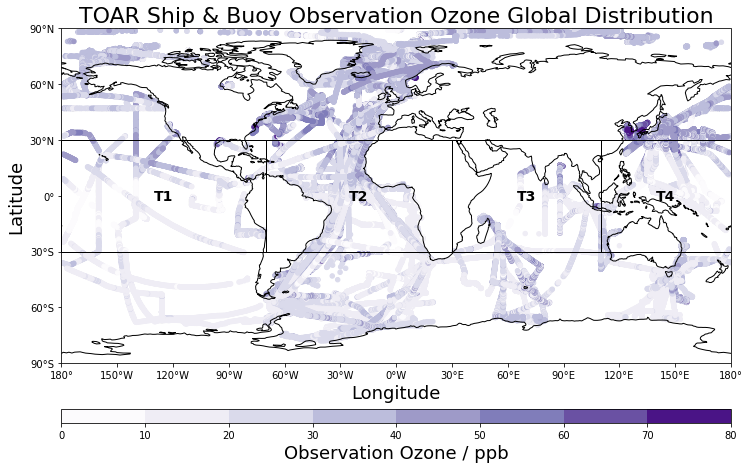

In [5]:
save_dir = '/home/ajp255/nethome/Data/Plots/'

# Define the longitude bands
longitude_bands = {
    'T1': (180, 290),
    'T2': (290, 390),
    'T3': (30, 110),
    'T4': (110, 180),
}

def plot_observation(df, title, colorbar_label, filename, custom_colors=None, vmin=None, vmax=None, num_colors=10):
    # Extract data from the DataFrame
    latitude = df['latitude']
    longitude = df['longitude']
    obs_ozone = df['obs_ozone'].dropna()

    # Create a custom colormap
    cmap = colors.ListedColormap(custom_colors) if custom_colors else plt.cm.get_cmap('coolwarm', num_colors)

    # Set the normalization bounds
    vmin = vmin if vmin is not None else obs_ozone.min()
    vmax = vmax if vmax is not None else obs_ozone.max()
    norm = colors.Normalize(vmin=vmin, vmax=vmax)

    # Create a scatter plot
    fig = plt.figure(figsize=(12, 17))
    ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    ax1.add_feature(cartopy.feature.COASTLINE)

    # Scatter plot with colormap
    sc = ax1.scatter(longitude, latitude, c=obs_ozone, cmap=cmap,
                    norm=norm, s=20, transform=ccrs.PlateCarree())

    # Add discrete colorbar at the bottom
    bounds = np.linspace(vmin, vmax, num_colors + 1)
    cbar = plt.colorbar(sc, ax=ax1, orientation='horizontal', ticks=bounds, pad=0.05, aspect=50)
    cbar.set_label(colorbar_label, fontsize=18)

    # Set title and labels
    ax1.set_title(title, fontsize=22)
    ax1.set_xlabel('Longitude', fontsize=18)
    ax1.set_ylabel('Latitude', fontsize=18)

    # Add gridlines and labels
    ax1.set_xticks(np.arange(-180, 181, 30), crs=ccrs.PlateCarree())
    ax1.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)

    # Add black boxes and names for the longitude bands
    for band, (lon_min, lon_max) in longitude_bands.items():
        rectangle = Rectangle((lon_min, -30), lon_max - lon_min, 60, transform=ccrs.PlateCarree(), 
                              edgecolor='black', facecolor='none')
        ax1.add_patch(rectangle)
        # Calculate the center of the rectangle for placing text
        center_lon = lon_min + (lon_max - lon_min) / 2
        ax1.text(center_lon, 0, band, transform=ccrs.PlateCarree(), 
                 horizontalalignment='center', verticalalignment='center', fontsize=14, color='black', weight='bold')

    # Save the plot
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()

# Example usage with custom color scale
custom_colors = ['#fcfbfd','#efedf5','#dadaeb','#bcbddc','#9e9ac8','#807dba','#6a51a3','#4a1486']
plot_observation(merge_df, 'TOAR Ship & Buoy Observation Ozone Global Distribution',
                'Observation Ozone / ppb', 'toar_ship_observation_ozone.png',
                custom_colors=custom_colors, vmin=0, vmax=80, num_colors=8)


Global distribution of ozone bias (model - observation)

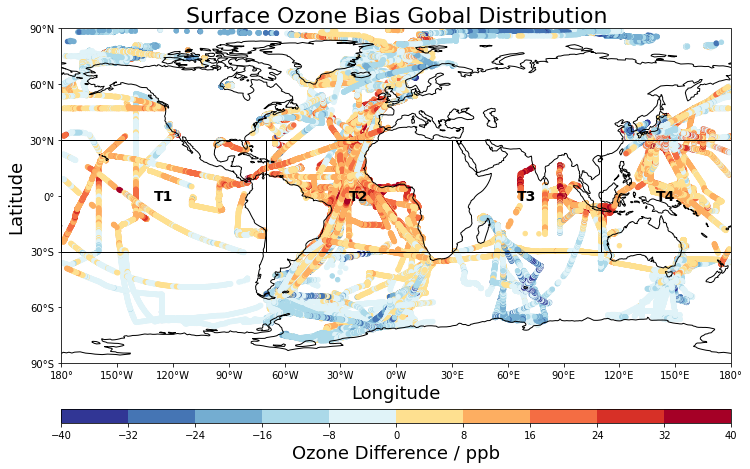

In [6]:
def plot_difference(df, title, colorbar_label, filename, custom_colors=None, vmin=None, vmax=None, num_colors=10):
    # Extract data from the DataFrame
    latitude = df['latitude']
    longitude = df['longitude']
    ozone_difference = df['ozone_difference'].dropna()

    # Create a custom colormap
    cmap = colors.ListedColormap(custom_colors) if custom_colors else plt.cm.get_cmap('coolwarm', num_colors)

    # Set the normalization bounds
    vmin = vmin if vmin is not None else ozone_difference.min()
    vmax = vmax if vmax is not None else ozone_difference.max()
    norm = colors.Normalize(vmin=vmin, vmax=vmax)

    # Create a scatter plot
    fig = plt.figure(figsize=(12, 17))
    ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
    ax1.add_feature(cartopy.feature.COASTLINE)

    # Scatter plot with colormap
    sc = ax1.scatter(longitude, latitude, c=ozone_difference, cmap=cmap,
                    norm=norm, s=20, transform=ccrs.PlateCarree())

    # Add discrete colorbar at the bottom
    bounds = np.linspace(vmin, vmax, num_colors + 1)
    cbar = plt.colorbar(sc, ax=ax1, orientation='horizontal', ticks=bounds, pad=0.05, aspect=50)
    cbar.set_label(colorbar_label, fontsize=18)

    # Set title and labels
    ax1.set_title(title, fontsize=22)
    ax1.set_xlabel('Longitude', fontsize=18)
    ax1.set_ylabel('Latitude', fontsize=18)

    # Add gridlines and labels
    ax1.set_xticks(np.arange(-180, 181, 30), crs=ccrs.PlateCarree())
    ax1.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)

    # Add black boxes for the longitude bands
    for band, (lon_min, lon_max) in longitude_bands.items():
        rectangle = Rectangle((lon_min, -30), lon_max - lon_min, 60, transform=ccrs.PlateCarree(),
                              edgecolor='black', facecolor='none', linewidth=1)
        ax1.add_patch(rectangle)
        # Calculate the center of the rectangle for placing text
        center_lon = lon_min + (lon_max - lon_min) / 2
        ax1.text(center_lon, 0, band, transform=ccrs.PlateCarree(), 
                 horizontalalignment='center', verticalalignment='center', fontsize=14, color='black', weight='bold')

    # Save the plot
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()

# Example usage with custom color scale
custom_colors = ['#313695', '#4575b4', '#74add1', '#abd9e9', '#e0f3f8', '#fee090', '#fdae61', '#f46d43', '#d73027', '#a50026']
plot_difference(merge_df, 'Surface Ozone Bias Gobal Distribution',
                'Ozone Difference / ppb', 'toar_surface_difference.png',
                custom_colors=custom_colors, vmin=-40, vmax=40, num_colors=10)

Latitude band histograms

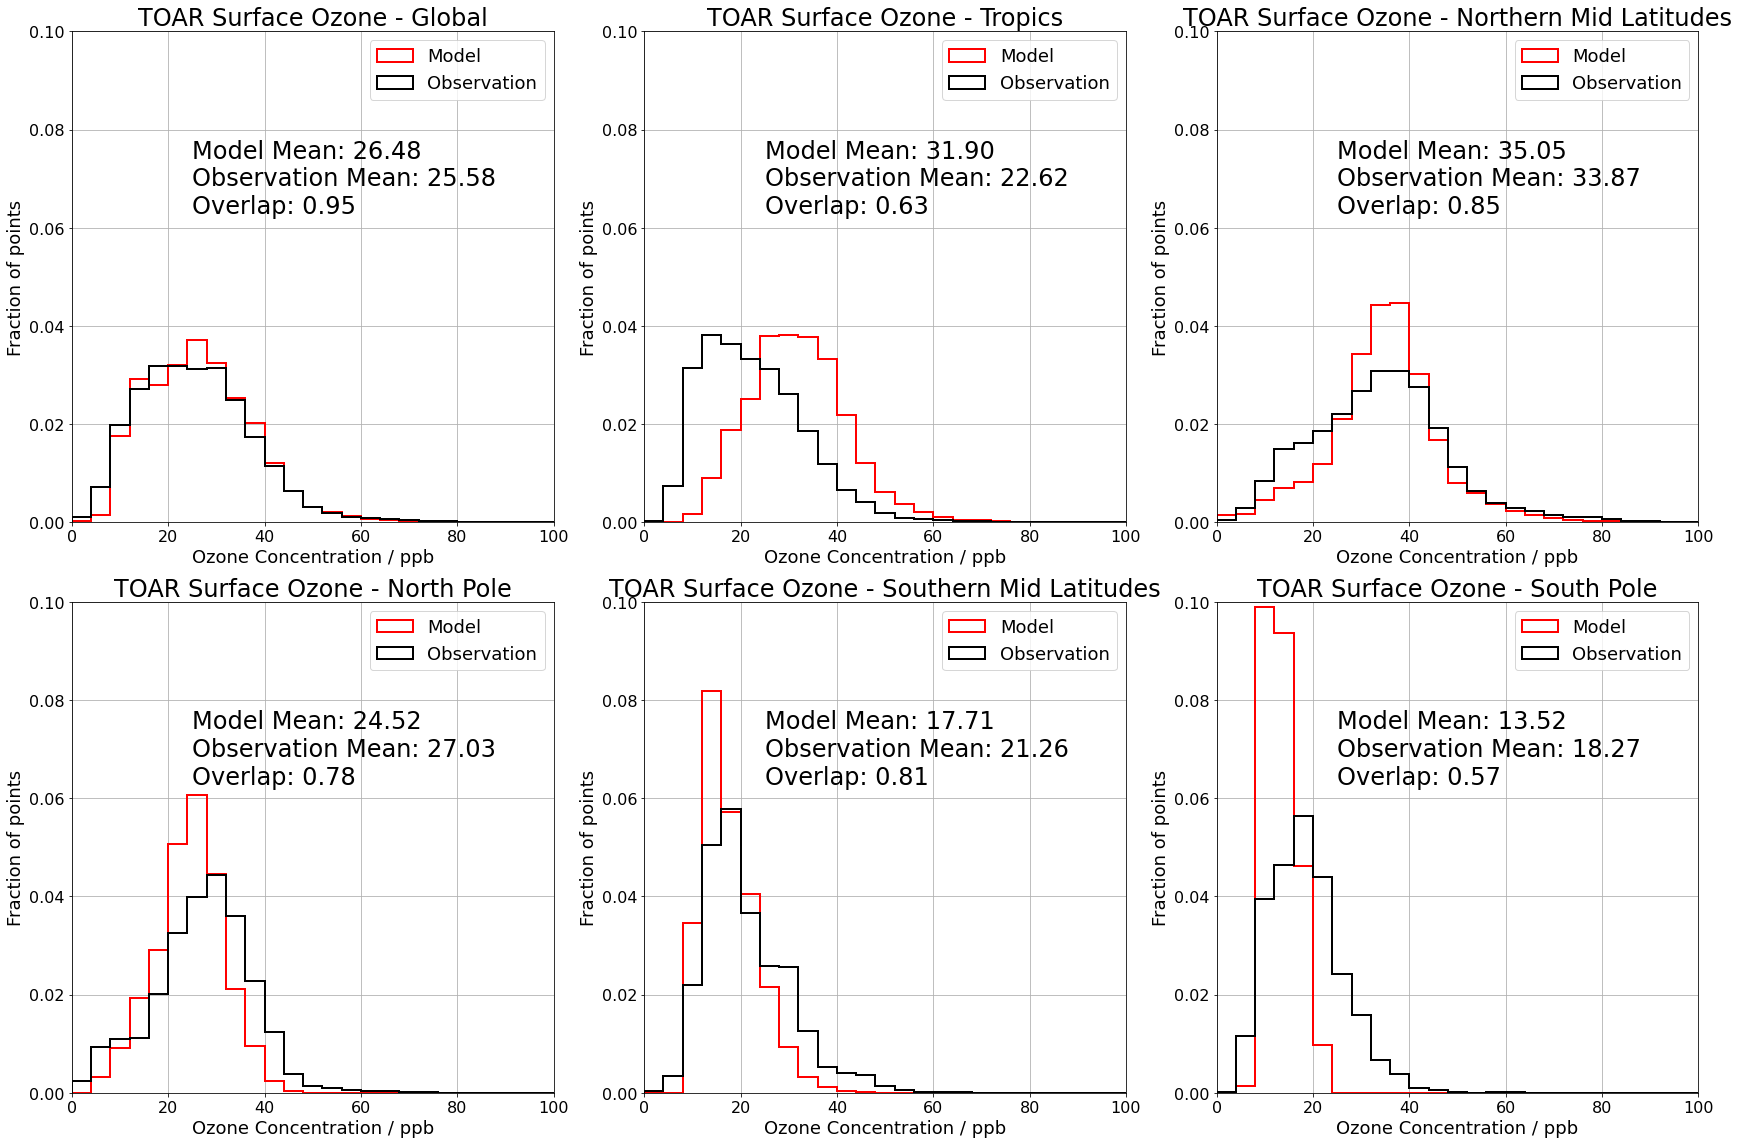

In [7]:
# Specify the directory to save plots
save_dir = '/home/ajp255/nethome/Data/Plots/'

# Define latitude bands with an additional 'Global' category
latitude_bands = {
    'Global': None,
    'Tropics': (-30, 30),
    'Northern Mid Latitudes': (30, 60),
    'North Pole': (60, 90),
    'Southern Mid Latitudes': (-60, -30),
    'South Pole': (-90, -60)
}

# Create a figure with a 2x3 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 16))  # Adjust figure size as needed
axes = axes.flatten()  # Flatten the axes array

# Iterate over each latitude band and its corresponding axis
for (band, lat_range), ax in zip(latitude_bands.items(), axes):
    if lat_range:  # Check if lat_range is not None
        lat_start, lat_end = lat_range
        # Filter data for the current latitude band
        band_data = merge_df[(merge_df['latitude'] >= lat_start) & (merge_df['latitude'] < lat_end)]
    else:
        # Use all data for the 'Global' category
        band_data = merge_df

    # Extract ozone data
    model_ozone = band_data['mod_ozone']
    ship_ozone = band_data['obs_ozone']

    # Define histogram bins and range
    binsize = 4
    binstart = 0
    binend = 100

    # Calculate mean for each dataset
    mean_model = np.mean(model_ozone)
    mean_ship = np.mean(ship_ozone)

    # Calculate degree of overlap
    overlap = np.sum(np.minimum(np.histogram(model_ozone, bins=np.arange(binstart, binend + binsize, binsize))[0],
                                np.histogram(ship_ozone, bins=np.arange(binstart, binend + binsize, binsize))[0])) / len(model_ozone)

    # Plot histograms on the current axis 'ax' instead of using plt directly
    ax.hist(model_ozone, bins=np.arange(binstart, binend + binsize, binsize),
            density=True, histtype='step', facecolor='red', edgecolor='red',
            linewidth=2, label="Model")

    ax.hist(ship_ozone, bins=np.arange(binstart, binend + binsize, binsize),
             density=True, histtype='step', facecolor='None', edgecolor='black',
             linewidth=2, label="Observation")

    # Customize the subplot
    ax.set_xlabel('Ozone Concentration / ppb', fontsize=18)
    ax.set_ylabel('Fraction of points', fontsize=18)
    ax.set_title(f'TOAR Surface Ozone - {band}', fontsize=24)
    ax.set_xlim(0, 100)  
    ax.set_ylim(0, 0.1)
    ax.grid(True)
    ax.legend(loc='upper right', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=16) 
    
    # Add mean and overlap information in the middle right of each subplot
    info_text = f'Model Mean: {mean_model:.2f}\nObservation Mean: {mean_ship:.2f}\nOverlap: {overlap:.2f}'
    ax.text(0.25, 0.7, info_text, transform=ax.transAxes, fontsize=24, va='center', ha='left')

# Adjust layout
plt.tight_layout()

# Save the entire figure to a file
save_path = os.path.join(save_dir, '6_ship_histograms.png')
plt.savefig(save_path, dpi=600, bbox_inches='tight')

# Display the figure
plt.show()

# Close the figure
plt.close(fig)

Split the data into Tropics regional dataframes

In [8]:
# Define the longitude bands
longitude_bands = {
    'T1': (180, 290),
    'T3': (30, 110),
    'T4': (110, 180),
}

# T2 is a special case with two ranges
T2_ranges = [(290, 360), (0, 30)]

# Filter data for latitude between -30 and 30
tropics_df = merge_df[(merge_df['latitude'] >= -30) & (merge_df['latitude'] <= 30)]

# Create a dictionary to hold the dataframes
dfs = {}

# Create the T1, T3, and T4 dataframes based on longitude bands
for band, (long_start, long_end) in longitude_bands.items():
    dfs[band] = tropics_df[(tropics_df['longitude'] >= long_start) & (tropics_df['longitude'] <= long_end)]

# Handle T2 separately due to its non-continuous nature
T2_df_1 = tropics_df[(tropics_df['longitude'] >= T2_ranges[0][0]) & (tropics_df['longitude'] <= T2_ranges[0][1])]
T2_df_2 = tropics_df[(tropics_df['longitude'] >= T2_ranges[1][0]) & (tropics_df['longitude'] <= T2_ranges[1][1])]
dfs['T2'] = pd.concat([T2_df_1, T2_df_2])

# Assign the dataframes to individual variables
T1, T2, T3, T4 = dfs['T1'], dfs['T2'], dfs['T3'], dfs['T4']

# Create a list of the dataframes for iteration
regional_dataframes = {'T1': T1, 'T2': T2, 'T3': T3, 'T4': T4}

Regional Tropics histograms

Region T1 - Model Ozone Std: 13.59, Observation Ozone Std: 16.44
Region T2 - Model Ozone Std: 8.79, Observation Ozone Std: 9.37
Region T3 - Model Ozone Std: 10.53, Observation Ozone Std: 10.41
Region T4 - Model Ozone Std: 9.77, Observation Ozone Std: 11.75


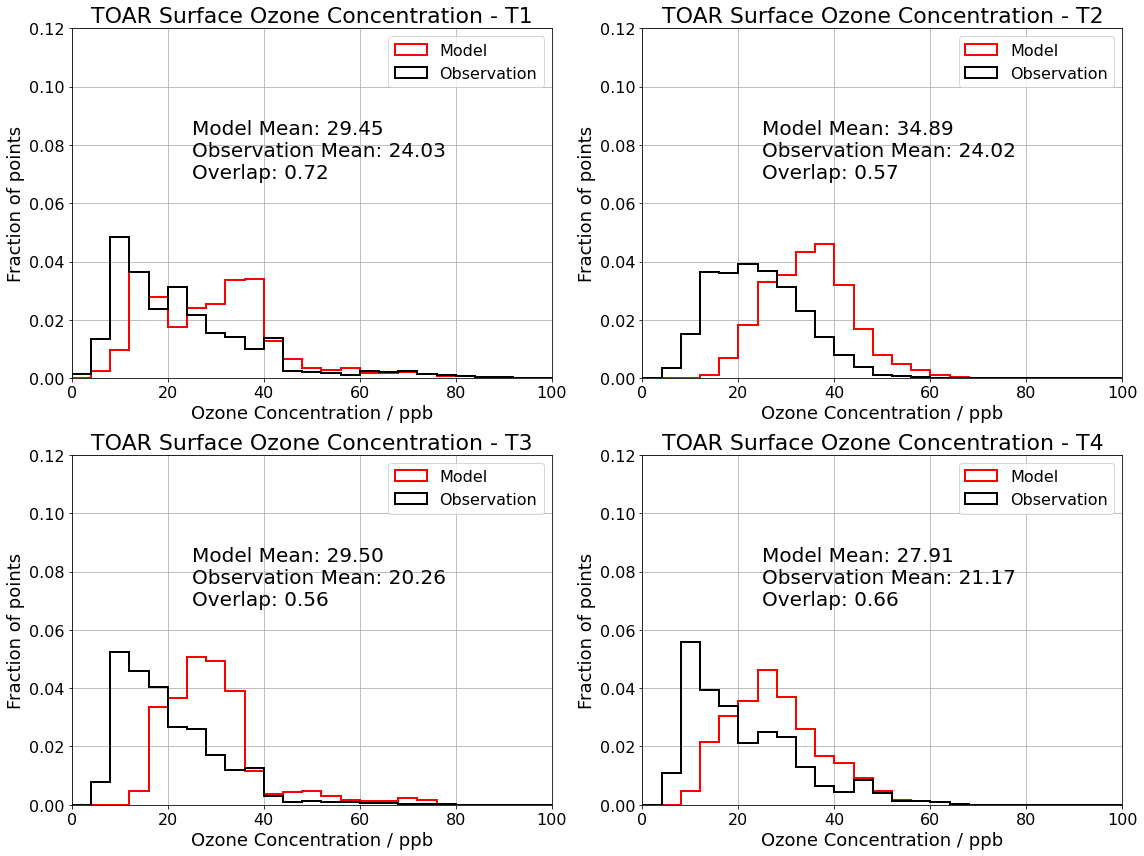

In [9]:
# Specify the directory to save plots
save_dir = '/home/ajp255/nethome/Data/Plots/'

# Create a figure with a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))  # Adjust figure size as needed
axes = axes.flatten()

# Iterate over each dataframe and its corresponding axis
for (band, band_data), ax in zip(regional_dataframes.items(), axes):
    # Extract ozone data
    model_ozone = band_data['mod_ozone']
    ship_ozone = band_data['obs_ozone']

    # Define histogram bins and range
    binsize = 4
    binstart = 0
    binend = 100

    # Calculate mean for each dataset
    mean_model = np.mean(model_ozone)
    std_model = np.std(model_ozone)
    mean_ship = np.mean(ship_ozone)
    std_ship = np.std(ship_ozone)

    # Calculate degree of overlap
    overlap = np.sum(np.minimum(np.histogram(model_ozone, bins=np.arange(binstart, binend + binsize, binsize))[0],
                                np.histogram(ship_ozone, bins=np.arange(binstart, binend + binsize, binsize))[0])) / len(model_ozone)

    # Plot histograms on the current axis 'ax' instead of using plt directly
    ax.hist(model_ozone, bins=np.arange(binstart, binend + binsize, binsize),
            density=True, histtype='step', facecolor='red', edgecolor='red',
            linewidth=2, label="Model")

    ax.hist(ship_ozone, bins=np.arange(binstart, binend + binsize, binsize),
            density=True, histtype='step', facecolor='None', edgecolor='black',
            linewidth=2, label="Observation")

    # Customize the subplot
    ax.set_xlabel('Ozone Concentration / ppb', fontsize=18)
    ax.set_ylabel('Fraction of points', fontsize=18)
    ax.set_title(f'TOAR Surface Ozone Concentration - {band}', fontsize=22)
    ax.set_xlim(0, 100)  # Adjust xlim as needed
    ax.set_ylim(0, 0.12)  # Adjust ylim as needed
    ax.grid(True)
    ax.legend(loc='upper right', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16) 

    # Add mean and overlap information in the middle right of each subplot
    info_text = f'Model Mean: {mean_model:.2f}\nObservation Mean: {mean_ship:.2f}\nOverlap: {overlap:.2f}'
    ax.text(0.25, 0.65, info_text, transform=ax.transAxes, fontsize=20, va='center', ha='left')

    print(f"Region {band} - Model Ozone Std: {std_model:.2f}, Observation Ozone Std: {std_ship:.2f}")
    
# Adjust layout
plt.tight_layout()

# Save the entire figure to a file
save_path = os.path.join(save_dir, 'regional_ship_ozone_histograms.png')
plt.savefig(save_path, dpi=600, bbox_inches='tight')

# Display the figure
plt.show()

# Close the figure
plt.close(fig)

Tropics regions broken down by season

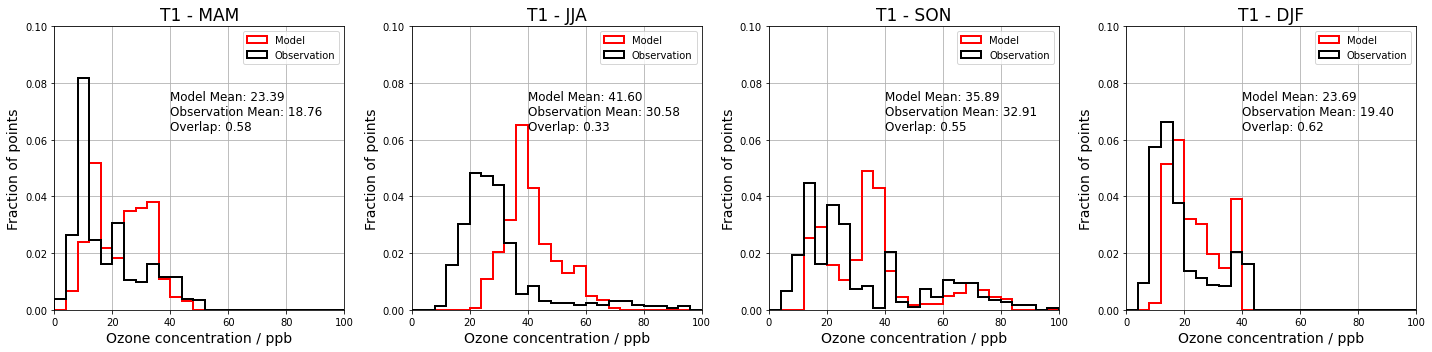

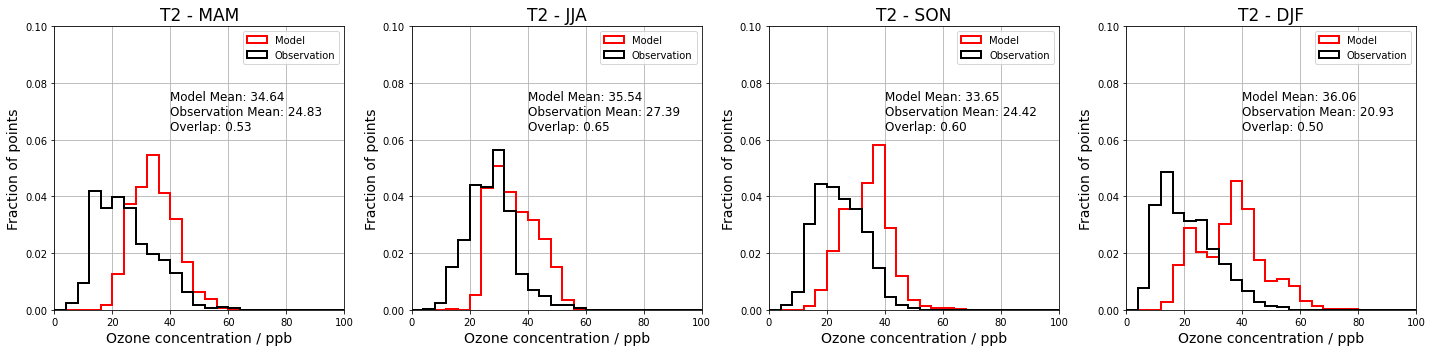

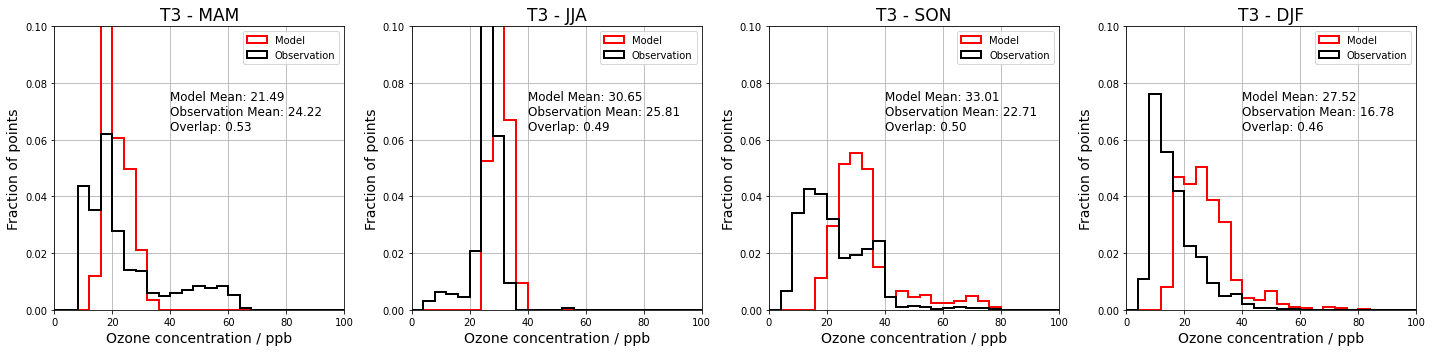

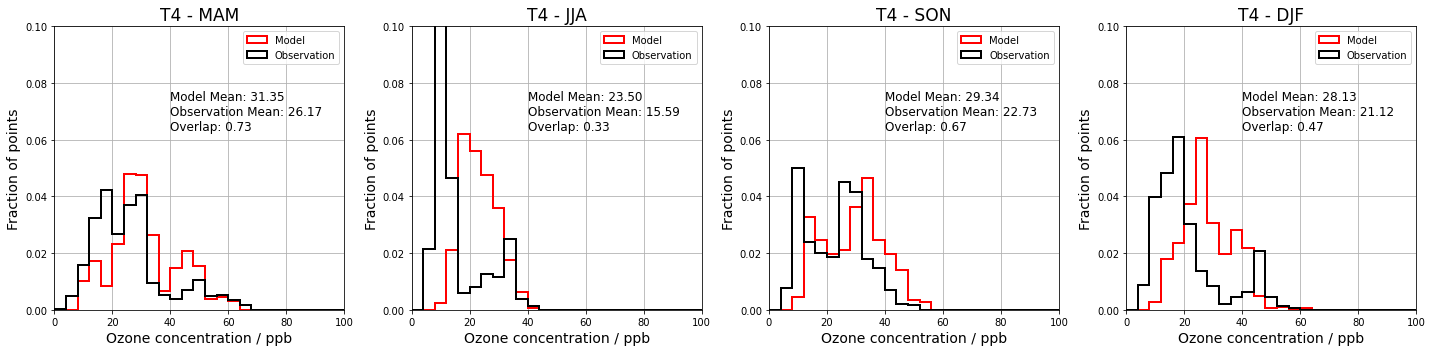

In [10]:
# Specify the directory to save plots
save_dir = '/home/ajp255/nethome/Data/Plots/'

# Define seasons
seasons = {
    'MAM': (3, 5),   # March, April, May
    'JJA': (6, 8),   # June, July, August
    'SON': (9, 11),  # September, October, November
    'DJF': (12, 2)   # December, January, February
}

# Iterate over each dataframe
for band, band_df in regional_dataframes.items():
    # Create a figure for the seasons in this longitude band
    fig, axes = plt.subplots(nrows=1, ncols=len(seasons), figsize=(20, 5))  # Adjust figure size as needed
    axes = axes.flatten()

    # Iterate over each season
    for j, (season, month_range) in enumerate(seasons.items()):
        ax = axes[j]

        start_month, end_month = month_range

        # Filter data for the current season
        if start_month <= end_month:
            band_season_data = band_df[
                (band_df['datetime'].dt.month >= start_month) & (band_df['datetime'].dt.month <= end_month)
            ]
        else:
            # Handle cyclical months
            band_season_data = band_df[
                (band_df['datetime'].dt.month >= start_month) | (band_df['datetime'].dt.month <= end_month)
            ]

        # Extract ozone data
        model_ozone = band_season_data['mod_ozone'].dropna()
        obs_ozone = band_season_data['obs_ozone'].dropna()

        # Skip plotting if there are no valid data points
        if model_ozone.empty and obs_ozone.empty:
            ax.text(0.5, 0.5, 'No data available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            continue

        # Define histogram bins and range
        binsize = 4
        binstart = 0
        binend = 100

        # Calculate mean for each dataset
        mean_model = np.mean(model_ozone)
        mean_obs = np.mean(obs_ozone)

        # Calculate degree of overlap
        overlap = np.sum(np.minimum(np.histogram(model_ozone, bins=np.arange(binstart, binend + binsize, binsize))[0],
                                    np.histogram(obs_ozone, bins=np.arange(binstart, binend + binsize, binsize))[0])) / len(model_ozone)

        # Plot histograms on the current axis
        ax.hist(model_ozone, bins=np.arange(binstart, binend + binsize, binsize),
                density=True, histtype='step', facecolor='red', edgecolor='red',
                linewidth=2, label="Model")
        ax.hist(obs_ozone, bins=np.arange(binstart, binend + binsize, binsize),
                density=True, histtype='step', facecolor='None', edgecolor='black',
                linewidth=2, label="Observation")

        # Customize the subplot
        ax.set_xlabel('Ozone concentration / ppb', fontsize=14)
        ax.set_ylabel('Fraction of points', fontsize=14)
        ax.set_title(f'{band} - {season}', fontsize=17)
        ax.set_xlim(0, 100)  # Adjust xlim as needed
        ax.set_ylim(0, 0.1)  # Adjust ylim as needed
        ax.grid(True)
        ax.legend(loc='upper right')

        # Add mean and overlap information in the middle right of each subplot
        info_text = f'Model Mean: {mean_model:.2f}\nObservation Mean: {mean_obs:.2f}\nOverlap: {overlap:.2f}'
        ax.text(0.40, 0.7, info_text, transform=ax.transAxes, fontsize=12, va='center', ha='left')

    # Adjust layout and show the figure
    plt.tight_layout()
    plt.show()

    # Close the figure
    plt.close(fig)

Annual variation in model and observation ozone 

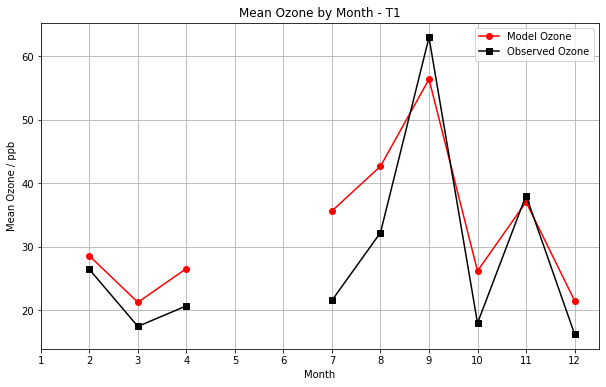

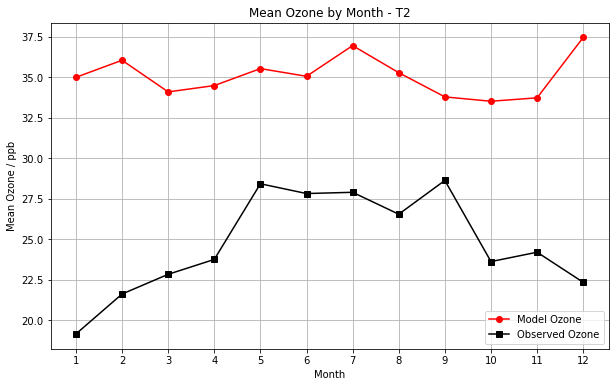

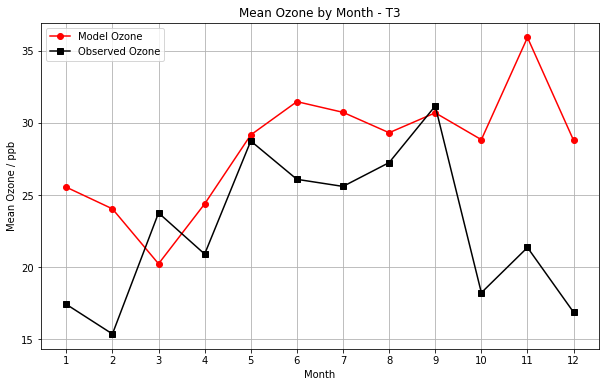

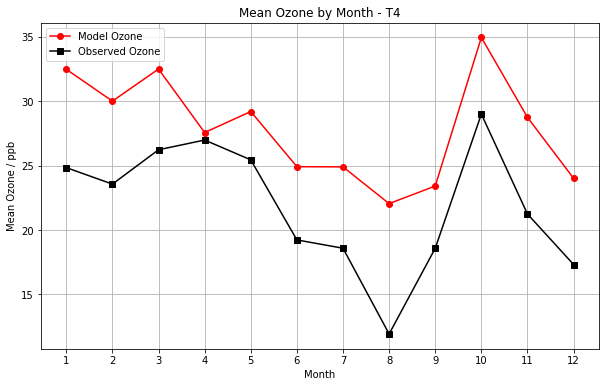

In [11]:
regional_dataframes_copy = {region: df.copy() for region, df in regional_dataframes.items()}

for region_name, df in regional_dataframes_copy.items():
    # Add the 'month' column
    df['month'] = df['datetime'].dt.month  # Modification is on the copy directly

    # Initialize lists to store mean mod_ozone and obs_ozone values and months
    mean_mod_ozone = []
    mean_obs_ozone = []
    months = list(range(1, 13))  # Months from 1 to 12

    # Calculate mean mod_ozone and obs_ozone for each month and store them in the lists
    for month in months:
        mean_mod = df[df['month'] == month]['mod_ozone'].mean()
        mean_obs = df[df['month'] == month]['obs_ozone'].mean()
        mean_mod_ozone.append(mean_mod)
        mean_obs_ozone.append(mean_obs)

    # Plotting for each region
    plt.figure(figsize=(10, 6))
    plt.plot(months, mean_mod_ozone, marker='o', linestyle='-', color='r', label='Model Ozone')
    plt.plot(months, mean_obs_ozone, marker='s', linestyle='-', color='k', label='Observed Ozone')
    plt.xlabel('Month')
    plt.ylabel('Mean Ozone / ppb')
    plt.title(f'Mean Ozone by Month - {region_name}')
    plt.xticks(months)
    plt.grid(True)
    plt.legend()
    plt.show()  
    plt.close()

Observation monthly average time series of observation data

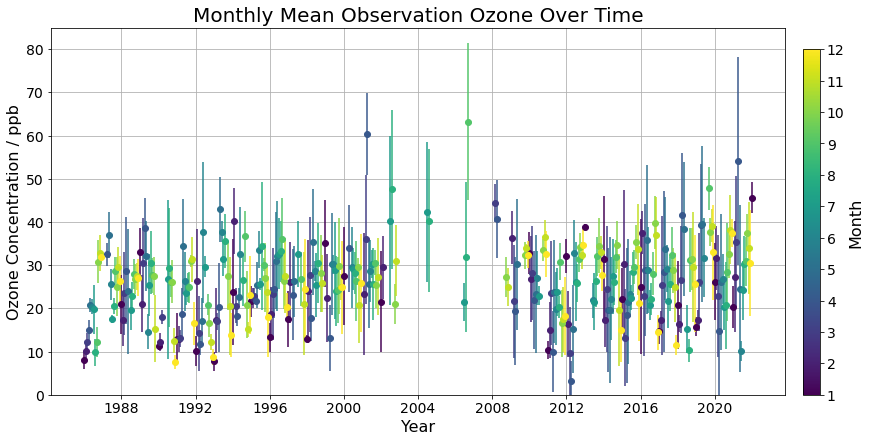

In [12]:
# Create a new DataFrame for processing
monthly_ozone_stats = obs_ship.copy()

# Convert 'time' from days since 1900 to datetime
monthly_ozone_stats['datetime'] = pd.to_datetime(monthly_ozone_stats['time'], unit='D', origin='1900-01-01')

# Extract year and month from 'datetime'
monthly_ozone_stats['year'] = monthly_ozone_stats['datetime'].dt.year
monthly_ozone_stats['month'] = monthly_ozone_stats['datetime'].dt.month

# Group by year and month and calculate mean and standard deviation for ozone
monthly_ozone_stats = monthly_ozone_stats.groupby(['year', 'month'])['ozone'].agg(['mean', 'std']).reset_index()

# Create a new 'Date' column for plotting
monthly_ozone_stats['Date'] = pd.to_datetime(monthly_ozone_stats[['year', 'month']].assign(DAY=1))

# Sort the DataFrame by 'Date'
monthly_ozone_stats = monthly_ozone_stats.sort_values(by='Date')

# Define a color map for the months
month_colors = plt.cm.viridis(np.linspace(0, 1, 12))

# Plotting
plt.figure(figsize=(12, 6))
for i, month in enumerate(month_colors):
    # Select data for the month
    monthly_data = monthly_ozone_stats[monthly_ozone_stats['month'] == i+1]
    
    # Plot with error bars
    plt.errorbar(monthly_data['Date'], monthly_data['mean'], yerr=monthly_data['std'], fmt='o', color=month, label=f'Month {i+1}')
    
plt.xlabel('Year', fontsize=16)
plt.ylabel('Ozone Concentration / ppb', fontsize=16)
plt.title('Monthly Mean Observation Ozone Over Time', fontsize=20)
plt.grid(True)
plt.tick_params(axis='both', labelsize=14)
plt.ylim(0, 85)

# Create a separate axis for the colorbar
cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # Position: [left, bottom, width, height]

# Add colorbar for the months
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=1, vmax=12))
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax, ticks=np.linspace(1, 12, 12), label='Month')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Month', fontsize=16)

# Use subplots_adjust instead of tight_layout to avoid compatibility issues
plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.1)

plt.savefig('/home/ajp255/nethome/Data/TrendPlots/ship_monthly_timeseries.png', dpi=600)

plt.show()
plt.close()


Separating the time series into early (1986-2000) and late (2008-2022) periods

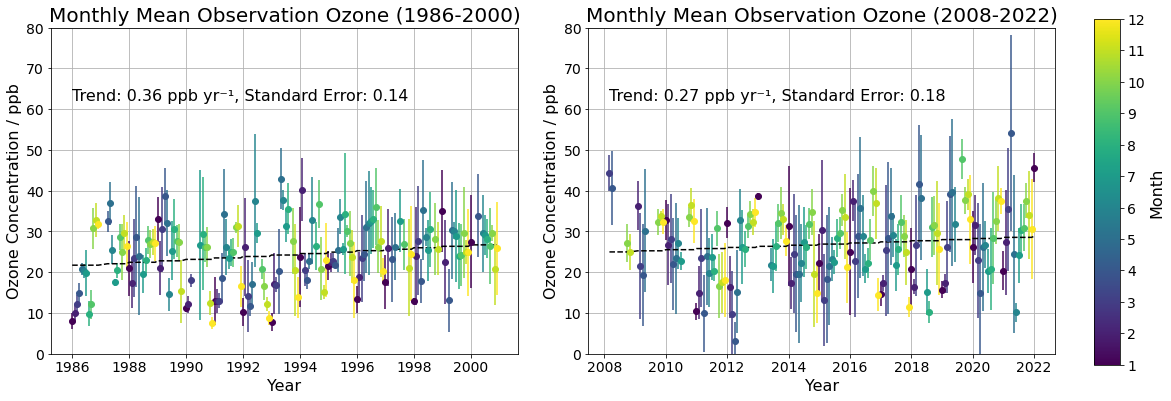

In [13]:
# Create a new DataFrame for processing
monthly_ozone_stats = obs_ship.copy()

# Convert 'time' from days since 1900 to datetime
monthly_ozone_stats['datetime'] = pd.to_datetime(monthly_ozone_stats['time'], unit='D', origin='1900-01-01')

# Extract year and month from 'datetime'
monthly_ozone_stats['year'] = monthly_ozone_stats['datetime'].dt.year
monthly_ozone_stats['month'] = monthly_ozone_stats['datetime'].dt.month

# Group by year and month and calculate mean and standard deviation for ozone
monthly_ozone_stats = monthly_ozone_stats.groupby(['year', 'month'])['ozone'].agg(['mean', 'std']).reset_index()

# Create a new 'Date' column for plotting
monthly_ozone_stats['Date'] = pd.to_datetime(monthly_ozone_stats[['year', 'month']].assign(DAY=1))

# Sort the DataFrame by 'Date'
monthly_ozone_stats = monthly_ozone_stats.sort_values(by='Date')

# Split the data into two periods: 1986-2000 and 2008-2022
period_1 = monthly_ozone_stats[(monthly_ozone_stats['year'] >= 1986) & (monthly_ozone_stats['year'] <= 2000)]
period_2 = monthly_ozone_stats[(monthly_ozone_stats['year'] >= 2008) & (monthly_ozone_stats['year'] <= 2022)]

# Define a color map for the months
month_colors = plt.cm.viridis(np.linspace(0, 1, 12))

# Plotting
plt.figure(figsize=(18, 6))  # Set the figure size to control width

# Plot for the period 1986-2000
plt.subplot(1, 2, 1)
for i, month in enumerate(month_colors):
    # Select data for the month
    monthly_data = period_1[period_1['month'] == i+1]
    
    # Plot with error bars
    plt.errorbar(monthly_data['Date'], monthly_data['mean'], yerr=monthly_data['std'], fmt='o', color=month)

# Calculate and plot trendline for the period 1986-2000
x_values_1 = period_1['Date'].dt.year
y_values_1 = period_1['mean']
slope_1, intercept_1, r_value_1, p_value_1, std_err_1 = linregress(x_values_1, y_values_1)
trendline_1 = slope_1 * x_values_1 + intercept_1
plt.plot(period_1['Date'], trendline_1, color='black', linestyle='--')

# Annotate with trend and standard error information
plt.text(period_1['Date'].min(), 65, f'Trend: {slope_1:.2f} ppb yr⁻¹, Standard Error: {std_err_1:.2f}', ha='left', va='top', fontsize=16)

plt.xlabel('Year', fontsize=16)
plt.ylabel('Ozone Concentration / ppb', fontsize=16)
plt.title('Monthly Mean Observation Ozone (1986-2000)', fontsize=20)
plt.grid(True)
plt.ylim(0, 80)
plt.tick_params(axis='both', labelsize=14)

# Plot for the period 2008-2022 with the same width as the first plot
plt.subplot(1, 2, 2)
for i, month in enumerate(month_colors):
    # Select data for the month
    monthly_data = period_2[period_2['month'] == i+1]
    
    # Plot with error bars
    plt.errorbar(monthly_data['Date'], monthly_data['mean'], yerr=monthly_data['std'], fmt='o', color=month)

# Calculate and plot trendline for the period 2008-2022
x_values_2 = period_2['Date'].dt.year
y_values_2 = period_2['mean']
slope_2, intercept_2, r_value_2, p_value_2, std_err_2 = linregress(x_values_2, y_values_2)
trendline_2 = slope_2 * x_values_2 + intercept_2
plt.plot(period_2['Date'], trendline_2, color='black', linestyle='--')

# Annotate with trend and standard error information
plt.text(period_2['Date'].min(), 65, f'Trend: {slope_2:.2f} ppb yr⁻¹, Standard Error: {std_err_2:.2f}', ha='left', va='top', fontsize=16)

plt.xlabel('Year', fontsize=16)
plt.ylabel('Ozone Concentration / ppb', fontsize=16)
plt.title('Monthly Mean Observation Ozone (2008-2022)', fontsize=20)
plt.grid(True)
plt.ylim(0, 80)
plt.tick_params(axis='both', labelsize=14)

# Create a separate axis for the colorbar
cax = plt.axes([0.93, 0.1, 0.02, 0.8])  # [left, bottom, width, height]

# Add colorbar for the months on the second plot only
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=1, vmax=12))
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax, ticks=np.linspace(1, 12, 12), label='Month')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Month', fontsize=16)

plt.subplots_adjust(wspace=0.15)  # Adjust the spacing between subplots

plt.savefig('/home/ajp255/nethome/Data/TrendPlots/ship_trendlines.png', dpi=600)

plt.show()

Observation average ozone mixing ratios by latitude between periods

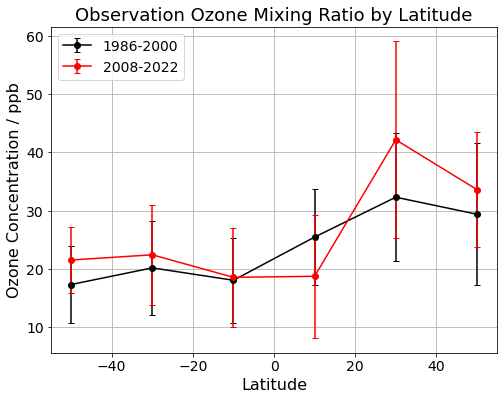

In [14]:
obs_ship.loc[:, 'datetime'] = pd.to_datetime(obs_ship['time'], unit='D', origin='1900-01-01')

# Define time periods using the datetime class from the datetime module
start_date_1986 = datetime.datetime(1986, 1, 1)
end_date_2000 = datetime.datetime(2000, 12, 31)
start_date_2008 = datetime.datetime(2008, 1, 1)
end_date_2022 = datetime.datetime(2022, 12, 31)

# Filter data for the two time periods
period_1986_2000 = obs_ship[(obs_ship['datetime'] >= start_date_1986) & (obs_ship['datetime'] <= end_date_2000)]
period_2008_2022 = obs_ship[(obs_ship['datetime'] >= start_date_2008) & (obs_ship['datetime'] <= end_date_2022)]

# Define latitude bins
lat_bins = np.arange(-60, 61, 20)  # Bins from -60 to 60 with a width of 20 degrees

# Bin the data by latitude and calculate mean and standard deviation for each bin and period
def bin_data(df, lat_bins):
    # Digitize the latitudes to get bin indices
    bin_indices = np.digitize(df['latitude'], lat_bins)
    # Calculate mean and standard deviation for each bin
    bin_means = [df[df['latitude'].between(lat_bins[i], lat_bins[i + 1])]['ozone'].mean() for i in range(len(lat_bins) - 1)]
    bin_stds = [df[df['latitude'].between(lat_bins[i], lat_bins[i + 1])]['ozone'].std() for i in range(len(lat_bins) - 1)]
    return bin_means, bin_stds

means_1986_2000, stds_1986_2000 = bin_data(period_1986_2000, lat_bins)
means_2008_2022, stds_2008_2022 = bin_data(period_2008_2022, lat_bins)

# Midpoints of the bins for plotting
bin_midpoints = (lat_bins[:-1] + lat_bins[1:]) / 2

# Now let's plot the data
plt.figure(figsize=(8, 6))

# Plot for 1986-2000
plt.errorbar(bin_midpoints, means_1986_2000, yerr=stds_1986_2000, color='black', fmt='-o', label='1986-2000', capsize=3)

# Plot for 2000-2022
plt.errorbar(bin_midpoints, means_2008_2022, yerr=stds_2008_2022, color='red', fmt='-o', label='2008-2022', capsize=3)

# Customizing the plot
plt.xlabel('Latitude', fontsize=16)
plt.ylabel('Ozone Concentration / ppb', fontsize=16)
plt.title('Observation Ozone Mixing Ratio by Latitude', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True)
plt.tick_params(axis='both', labelsize=14)

# Display the plot
plt.savefig('/home/ajp255/nethome/Data/TrendPlots/latitude_distribution.png', dpi=600)
plt.show()

Observation ozone mixing ratio frquency distributions by latitude between periods

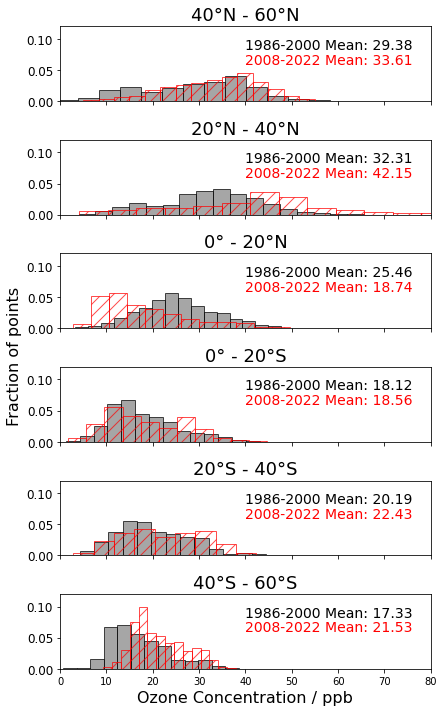

In [15]:
# Define latitude bands
latitude_bands = {
    '40°N - 60°N': (40, 60),
    '20°N - 40°N': (20, 40),
    '0° - 20°N': (0, 20),
    '0° - 20°S': (-20, 0),
    '20°S - 40°S': (-40, -20),
    '40°S - 60°S': (-60, -40)
}

# Set up the plot
fig, axes = plt.subplots(nrows=len(latitude_bands), ncols=1, figsize=(6, 10), sharex=True)

# Create histograms for each latitude band for both time periods
for ax, (label, (lat_min, lat_max)) in zip(axes, latitude_bands.items()):
    # Filter the data for the current latitude band for the first period
    band_data_1986_2000 = period_1986_2000[(period_1986_2000['latitude'] >= lat_min) & (period_1986_2000['latitude'] < lat_max)]
    # Filter the data for the current latitude band for the second period
    band_data_2008_2022 = period_2008_2022[(period_2008_2022['latitude'] >= lat_min) & (period_2008_2022['latitude'] < lat_max)]
    
    # Plot the histograms
    ax.hist(band_data_1986_2000['ozone'], bins=20, density=True, facecolor='grey', edgecolor='black', alpha=0.7, label='1986-2000')
    ax.hist(band_data_2008_2022['ozone'], bins=20, density=True, facecolor='None', edgecolor='red', alpha=0.7, label='2008-2022', hatch='//')
    
    # Set the title for the subplot
    ax.set_title(label, fontsize=18)
    ax.set_xlim(0, 80)
    ax.set_ylim(0, 0.12)
    
    # Calculate model and observed averages
    early_avg = band_data_1986_2000['ozone'].mean()
    late_avg = band_data_2008_2022['ozone'].mean()
    
    # Annotate model and observed averages at the top right
    early_text = f'1986-2000 Mean: {early_avg:.2f}'
    late_text = f'2008-2022 Mean: {late_avg:.2f}'
    ax.text(0.95, 0.75, early_text, transform=ax.transAxes, fontsize=14, va='center', ha='right', color='black')
    ax.text(0.95, 0.55, late_text, transform=ax.transAxes, fontsize=14, va='center', ha='right', color='red')
    ax.tick_params(axis='y', labelsize=12)

# Set the common x-axis label and adjust font size
axes[-1].set_xlabel('Ozone Concentration / ppb', fontsize=16)

# Set common y-axis label for the figure and adjust font size
fig.text(-0.02, 0.5, 'Fraction of points', va='center', rotation='vertical', fontsize=16)

plt.subplots_adjust(left=0.5, right=0.95, top=0.95, bottom=0.05)

# Adjust layout
plt.tight_layout()
plt.savefig('/home/ajp255/nethome/Data/TrendPlots/frequency_distributions.png', dpi=600, bbox_inches='tight')

plt.show()

Model monthly average time series of observation data

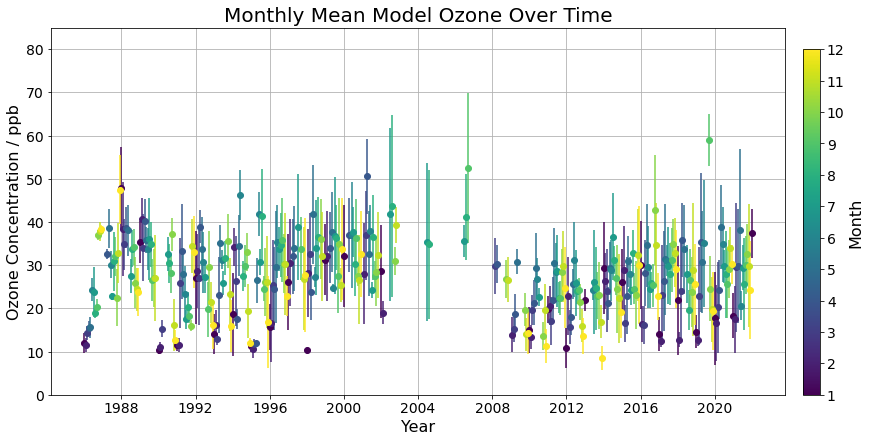

In [16]:
# Create a new DataFrame for processing
monthly_ozone_stats = mod_ship.copy()

# Convert 'time' from days since 1900 to datetime
monthly_ozone_stats['datetime'] = pd.to_datetime(monthly_ozone_stats['time'], unit='D', origin='1900-01-01')

# Extract year and month from 'datetime'
monthly_ozone_stats['year'] = monthly_ozone_stats['datetime'].dt.year
monthly_ozone_stats['month'] = monthly_ozone_stats['datetime'].dt.month

# Group by year and month and calculate mean and standard deviation for ozone
monthly_ozone_stats = monthly_ozone_stats.groupby(['year', 'month'])['ozone'].agg(['mean', 'std']).reset_index()

# Create a new 'Date' column for plotting
monthly_ozone_stats['Date'] = pd.to_datetime(monthly_ozone_stats[['year', 'month']].assign(DAY=1))

# Sort the DataFrame by 'Date'
monthly_ozone_stats = monthly_ozone_stats.sort_values(by='Date')

# Define a color map for the months
month_colors = plt.cm.viridis(np.linspace(0, 1, 12))

# Plotting
plt.figure(figsize=(12, 6))
for i, month in enumerate(month_colors):
    # Select data for the month
    monthly_data = monthly_ozone_stats[monthly_ozone_stats['month'] == i+1]
    
    # Plot with error bars
    plt.errorbar(monthly_data['Date'], monthly_data['mean'], yerr=monthly_data['std'], fmt='o', color=month, label=f'Month {i+1}')
    
# Adjust the font sizes
plt.xlabel('Year', fontsize=16)
plt.ylabel('Ozone Concentration / ppb', fontsize=16)
plt.title('Monthly Mean Model Ozone Over Time', fontsize=20)
plt.tick_params(axis='both', labelsize=14)
plt.grid(True)
plt.ylim(0, 85)

# Create a separate axis for the colorbar
cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # Position: [left, bottom, width, height]

# Add colorbar for the months
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=1, vmax=12))
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax, ticks=np.linspace(1, 12, 12), label='Month')
cbar.ax.tick_params(labelsize=14)  # Adjust colorbar tick label font size
cbar.set_label('Month', fontsize=16)

# Use subplots_adjust to arrange the plot and colorbar within the figure
plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.1)

plt.savefig('/home/ajp255/nethome/Data/TrendPlots/model_monthly_timeseries.png', dpi=600)

plt.show()
plt.close()

Separating the time series into early (1986-2000) and late (2008-2022) periods

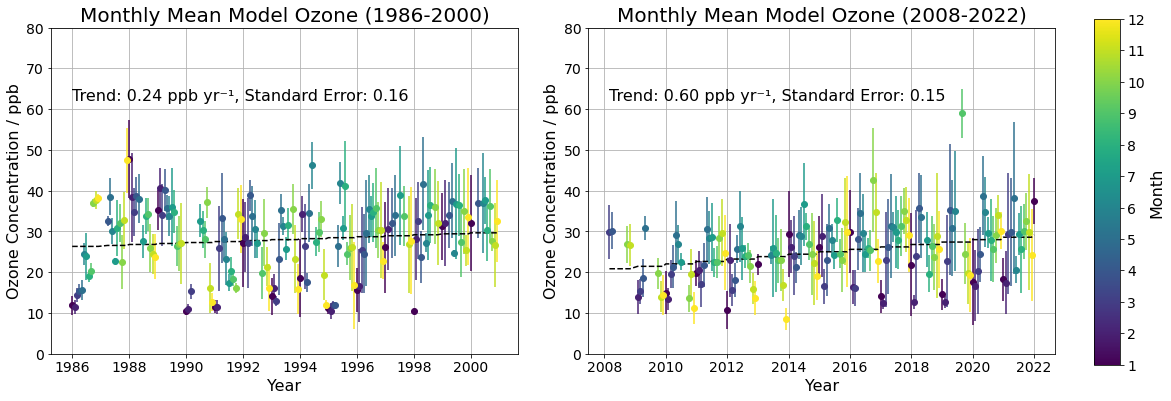

In [17]:
# Create a new DataFrame for processing
monthly_ozone_stats = mod_ship.copy()

# Convert 'time' from days since 1900 to datetime
monthly_ozone_stats['datetime'] = pd.to_datetime(monthly_ozone_stats['time'], unit='D', origin='1900-01-01')

# Extract year and month from 'datetime'
monthly_ozone_stats['year'] = monthly_ozone_stats['datetime'].dt.year
monthly_ozone_stats['month'] = monthly_ozone_stats['datetime'].dt.month

# Group by year and month and calculate mean and standard deviation for ozone
monthly_ozone_stats = monthly_ozone_stats.groupby(['year', 'month'])['ozone'].agg(['mean', 'std']).reset_index()

# Create a new 'Date' column for plotting
monthly_ozone_stats['Date'] = pd.to_datetime(monthly_ozone_stats[['year', 'month']].assign(DAY=1))

# Sort the DataFrame by 'Date'
monthly_ozone_stats = monthly_ozone_stats.sort_values(by='Date')

# Split the data into two periods: 1986-2000 and 2008-2022
period_1 = monthly_ozone_stats[(monthly_ozone_stats['year'] >= 1986) & (monthly_ozone_stats['year'] <= 2000)]
period_2 = monthly_ozone_stats[(monthly_ozone_stats['year'] >= 2008) & (monthly_ozone_stats['year'] <= 2022)]

# Define a color map for the months
month_colors = plt.cm.viridis(np.linspace(0, 1, 12))

# Plotting
plt.figure(figsize=(18, 6))  # Set the figure size to control width

# Plot for the period 1986-2000
plt.subplot(1, 2, 1)
for i, month in enumerate(month_colors):
    # Select data for the month
    monthly_data = period_1[period_1['month'] == i+1]
    
    # Plot with error bars
    plt.errorbar(monthly_data['Date'], monthly_data['mean'], yerr=monthly_data['std'], fmt='o', color=month)

# Calculate and plot trendline for the period 1986-2000
x_values_1 = period_1['Date'].dt.year
y_values_1 = period_1['mean']
slope_1, intercept_1, r_value_1, p_value_1, std_err_1 = linregress(x_values_1, y_values_1)
trendline_1 = slope_1 * x_values_1 + intercept_1
plt.plot(period_1['Date'], trendline_1, color='black', linestyle='--')

# Annotate with trend and standard error information
plt.text(period_1['Date'].min(), 65, f'Trend: {slope_1:.2f} ppb yr⁻¹, Standard Error: {std_err_1:.2f}', ha='left', va='top', fontsize=16)

plt.xlabel('Year', fontsize=16)
plt.ylabel('Ozone Concentration / ppb', fontsize=16)
plt.title('Monthly Mean Model Ozone (1986-2000)', fontsize=20)
plt.grid(True)
plt.ylim(0, 80)
plt.tick_params(axis='both', labelsize=14)

# Plot for the period 2008-2022 with the same width as the first plot
plt.subplot(1, 2, 2)
for i, month in enumerate(month_colors):
    # Select data for the month
    monthly_data = period_2[period_2['month'] == i+1]
    
    # Plot with error bars
    plt.errorbar(monthly_data['Date'], monthly_data['mean'], yerr=monthly_data['std'], fmt='o', color=month)

# Calculate and plot trendline for the period 2008-2022
x_values_2 = period_2['Date'].dt.year
y_values_2 = period_2['mean']
slope_2, intercept_2, r_value_2, p_value_2, std_err_2 = linregress(x_values_2, y_values_2)
trendline_2 = slope_2 * x_values_2 + intercept_2
plt.plot(period_2['Date'], trendline_2, color='black', linestyle='--')

# Annotate with trend and standard error information
plt.text(period_2['Date'].min(), 65, f'Trend: {slope_2:.2f} ppb yr⁻¹, Standard Error: {std_err_2:.2f}', ha='left', va='top', fontsize=16)

plt.xlabel('Year', fontsize=16)
plt.ylabel('Ozone Concentration / ppb', fontsize=16)
plt.title('Monthly Mean Model Ozone (2008-2022)', fontsize=20)
plt.grid(True)
plt.ylim(0, 80)
plt.tick_params(axis='both', labelsize=14)

# Create a separate axis for the colorbar
cax = plt.axes([0.93, 0.1, 0.02, 0.8])  # [left, bottom, width, height]

# Add colorbar for the months on the second plot only
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=1, vmax=12))
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax, ticks=np.linspace(1, 12, 12), label='Month')
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Month', fontsize=16)

plt.subplots_adjust(wspace=0.15)  # Adjust the spacing between subplots

plt.savefig('/home/ajp255/nethome/Data/TrendPlots/mod_ship_trendlines.png', dpi=600)

plt.show()

Model average ozone mixing ratios by latitude between periods

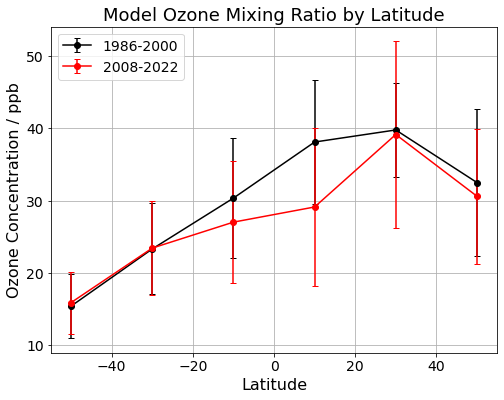

In [21]:
mod_ship_copy = mod_ship.copy()
mod_ship_copy.loc[:, 'datetime'] = pd.to_datetime(mod_ship_copy['time'], unit='D', origin='1900-01-01')

# Define time periods in Unix Timestamp or compatible format for your dataset
start_date_1986 = datetime.datetime(1986, 1, 1)
end_date_2000 = datetime.datetime(2000, 12, 31)
start_date_2008 = datetime.datetime(2008, 1, 1)
end_date_2022 = datetime.datetime(2022, 12, 31)

# Filter data for the two time periods
period_1986_2000 = mod_ship_copy[(mod_ship_copy['datetime'] >= start_date_1986) & (mod_ship_copy['datetime'] <= end_date_2000)]
period_2008_2022 = mod_ship_copy[(mod_ship_copy['datetime'] >= start_date_2008) & (mod_ship_copy['datetime'] <= end_date_2022)]

# Define latitude bins
lat_bins = np.arange(-60, 61, 20)  # Bins from -60 to 60 with a width of 20 degrees

# Bin the data by latitude and calculate mean and standard deviation for each bin and period
def bin_data(df, lat_bins):
    # Digitize the latitudes to get bin indices
    bin_indices = np.digitize(df['latitude'], lat_bins)
    # Calculate mean and standard deviation for each bin
    bin_means = [df[df['latitude'].between(lat_bins[i], lat_bins[i + 1])]['ozone'].mean() for i in range(len(lat_bins) - 1)]
    bin_stds = [df[df['latitude'].between(lat_bins[i], lat_bins[i + 1])]['ozone'].std() for i in range(len(lat_bins) - 1)]
    return bin_means, bin_stds

means_1986_2000, stds_1986_2000 = bin_data(period_1986_2000, lat_bins)
means_2008_2022, stds_2008_2022 = bin_data(period_2008_2022, lat_bins)

# Midpoints of the bins for plotting
bin_midpoints = (lat_bins[:-1] + lat_bins[1:]) / 2

# Now let's plot the data
plt.figure(figsize=(8, 6))

# Plot for 1986-2000
plt.errorbar(bin_midpoints, means_1986_2000, yerr=stds_1986_2000, color='black', fmt='-o', label='1986-2000', capsize=3)

# Plot for 2000-2022
plt.errorbar(bin_midpoints, means_2008_2022, yerr=stds_2008_2022, color='red', fmt='-o', label='2008-2022', capsize=3)

# Customizing the plot
plt.xlabel('Latitude', fontsize=16)
plt.ylabel('Ozone Concentration / ppb', fontsize=16)
plt.title('Model Ozone Mixing Ratio by Latitude', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True)
plt.tick_params(axis='both', labelsize=14)

# Display the plot
plt.savefig('/home/ajp255/nethome/Data/TrendPlots/mod_ship_copy_latitude_distribution.png', dpi=600)
plt.show()

Model ozone mixing ratio frquency distributions by latitude between periods

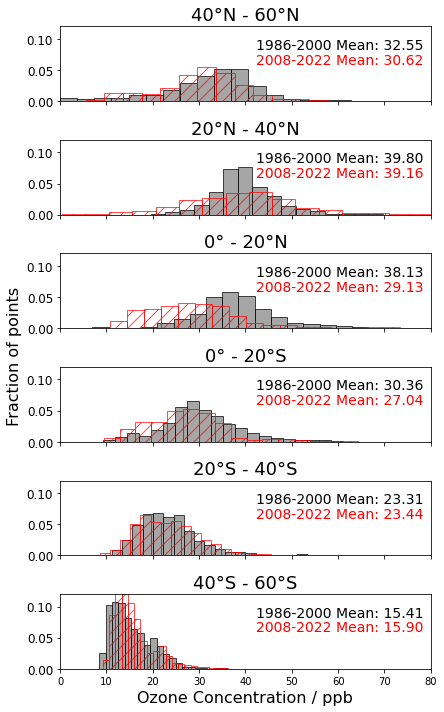

In [20]:
# Define latitude bands
latitude_bands = {
    '40°N - 60°N': (40, 60),
    '20°N - 40°N': (20, 40),
    '0° - 20°N': (0, 20),
    '0° - 20°S': (-20, 0),
    '20°S - 40°S': (-40, -20),
    '40°S - 60°S': (-60, -40)
}

# Set up the plot
fig, axes = plt.subplots(nrows=len(latitude_bands), ncols=1, figsize=(6, 10), sharex=True)

# Create histograms for each latitude band for both time periods
for ax, (label, (lat_min, lat_max)) in zip(axes, latitude_bands.items()):
    # Filter the data for the current latitude band for the first period
    band_data_1986_2000 = period_1986_2000[(period_1986_2000['latitude'] >= lat_min) & (period_1986_2000['latitude'] < lat_max)]
    # Filter the data for the current latitude band for the second period
    band_data_2008_2022 = period_2008_2022[(period_2008_2022['latitude'] >= lat_min) & (period_2008_2022['latitude'] < lat_max)]
    
    # Plot the histograms
    ax.hist(band_data_1986_2000['ozone'], bins=20, density=True, facecolor='grey', edgecolor='black', alpha=0.7, label='1986-2000')
    ax.hist(band_data_2008_2022['ozone'], bins=20, density=True, facecolor='None', edgecolor='red', alpha=0.7, label='2008-2022', hatch='//')
    
    # Set the title for the subplot
    ax.set_title(label, fontsize=18)
    ax.set_xlim(0, 80)
    ax.set_ylim(0, 0.12)
    
    # Calculate model and observed averages
    early_avg = band_data_1986_2000['ozone'].mean()
    late_avg = band_data_2008_2022['ozone'].mean()
    
    # Annotate model and observed averages at the top right
    early_text = f'1986-2000 Mean: {early_avg:.2f}'
    late_text = f'2008-2022 Mean: {late_avg:.2f}'
    ax.text(0.98, 0.75, early_text, transform=ax.transAxes, fontsize=14, va='center', ha='right', color='black')
    ax.text(0.98, 0.55, late_text, transform=ax.transAxes, fontsize=14, va='center', ha='right', color='red')
    ax.tick_params(axis='y', labelsize=12)

# Set the common labels
axes[-1].set_xlabel('Ozone Concentration / ppb', fontsize=16)

# Set common y-axis label for the figure and adjust font size
fig.text(-0.02, 0.5, 'Fraction of points', va='center', rotation='vertical', fontsize=16)

plt.subplots_adjust(left=0.5, right=0.95, top=0.95, bottom=0.05)

# Adjust layout
plt.tight_layout()
plt.savefig('/home/ajp255/nethome/Data/TrendPlots/mod_ship_frequency_distributions.png', dpi=600, bbox_inches='tight')

plt.show()